In [20]:
import os
import sys
import logging
import pickle
import mlflow
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from warnings import filterwarnings
filterwarnings('ignore')

from minio import Minio

# settings
MINIO_HOST = os.environ.get('MINIO_HOST', '')
MINIO_ACCESS_KEY = os.environ.get('MINIO_ACCESS_KEY', '')
MINIO_SECRET_KEY = os.environ.get('MINIO_SECRET_KEY', '')

os.environ['MLFLOW_TRACKING_URI'] = ""
os.environ['MLFLOW_S3_ENDPOINT_URL'] = ""
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''

In [21]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")
log = logging.getLogger(__name__)

In [22]:
class VesselFuelConsumptionRegression(object):
    def __init__(self):
        self.random_state = 42
        self.bucket = 'uploads'
        self.directory = 'data'
        self.scaler = MinMaxScaler()
        
        self.new_columns = ['vessel_fuel_consumption']
        self.date_col = ['measurement_time']
        
        self.numerical_columns = [
            'AE_FO_consumption', 'available_max_power',
             'crankcase_press', 'cyl_chargeair_press',
             'draught_aft_side', 'draught_fore_side',
             'engine_speed', 'ME_FO_consumption',
             'propeller_shaft_output', 'propeller_shaft_rpm',
             'propeller_shaft_thrust', 'cyl_chargeair_temp',
             'ship_speed_actual', 'Ship_SpeedLOG', 
             'cyl_exh_gas_temp_mean','torque',
             'AE_FO_outlet_flow', 'AE_FO_outlet_Temp',
             'Eng_in_HTCW_press', 'Eng_in_Jacket_HTCW_temp',
             'Eng_out_Jacket_HTCW_temp', 'Eng_Relative_load',
             'FO_Rack_position', 'FO_inlet_press',
             'fueloil_inlet_temperature', 'ME_FO_inlet_flow',
             'ME_FO_outlet_Temp', 'ME_FO_outlet_flow',
             'LO_Filter_P', 'LO_filter_in_press',
             'LO_in_press', 'LO_in_temp',
             'LO_out_temp_TC', 'LO_cooler_CW_out_temp'
        ]
        self.categorical_columns = [
            'DG_1_condition','DG_2_condition',
            'DG_3_condition','DG_4_condition',
            'DG_5_condition','ship_inclination'
        ]
        
        self.columns_used = self.date_col + self.numerical_columns + self.categorical_columns
        self.for_normalization_cols = self.numerical_columns + self.new_columns
        
        self.monitoring_col = ['vessel_fuel_consumption']
        self.drop_cols = ['AE_FO_consumption', 'ME_FO_consumption']
    
    def load_dataset_(self, ship_id):
        client = Minio(
            MINIO_HOST,
            access_key=MINIO_ACCESS_KEY,
            secret_key=MINIO_SECRET_KEY,
            secure=False
        )
        data_path = f'{self.directory}/{ship_id}.csv'
        obj = client.get_object(self.bucket, data_path)
        df = pd.read_csv(obj, parse_dates=['measurement_time'], usecols=self.columns_used)
        return df
    
    def _pre_process(self, df):
        df = df.dropna()
        min_crankcase_press_value = -1 * min(df['crankcase_press'])
        min_propeller_shaft_thrust_value = -1 * min(df['propeller_shaft_thrust'])
        min_lo_filter_p_value = -1*min(df['LO_Filter_P'])
        
#         min_properties = {
#             'min_crankcase_press_value': min_crankcase_press_value,
#             'min_propeller_shaft_thrust_value': min_propeller_shaft_thrust_value,
#             'min_lo_filter_p_value': min_lo_filter_p_value
#         }

#         df['crankcase_press'] = df['crankcase_press'].apply(
#             lambda x: x + min_crankcase_press_value
#         )
#         df['propeller_shaft_thrust'] = df['propeller_shaft_thrust'].apply(
#             lambda x: x + min_propeller_shaft_thrust_value
#         )
#         df['LO_Filter_P'] = df['LO_Filter_P'].apply(
#             lambda x: x + min_lo_filter_p_value
#         )
        df['vessel_fuel_consumption'] = df['AE_FO_consumption'] + df['AE_FO_consumption']
        return df
    
    def _normalize(self, df):
        df[self.for_normalization_cols] = self.scaler.transform(
            df[self.for_normalization_cols]
        )
        # remove zero variance data
        df = df.loc[:, (df != df.iloc[0]).any()]
        return df
    
    def _data_preparation(self, normalized_df, test_size=0.20):
        abort_cols = self.monitoring_col + self.drop_cols + self.date_col
        Y = normalized_df[self.monitoring_col]
        X = normalized_df[[column for column in normalized_df.columns if column not in abort_cols]]
        X_train,X_test,Y_train,Y_test=train_test_split(
            X,Y,test_size=test_size,random_state=self.random_state
        )
        return X_train,X_test,Y_train,Y_test
    
    
    def _metrics_gen(self, true_value, predicted):
        mae = mean_absolute_error(true_value, predicted)
        mse = mean_squared_error(true_value, predicted)
        r2 = r2_score(true_value, predicted)
        return mae, mse, r2
    
    def _store_scaler(self, path='scaler.pkl'):
        pickle.dump(self.scaler, open(path, 'wb'))
        
    
    @staticmethod
    def _log_to_mlflow(
        experiment_name,
        trained_models_dict,
        metrics_dict,
        scaler_obj_path,
        params = None
    ):
        mlflow.set_experiment(experiment_name)
        with mlflow.start_run():
            
            mlflow.log_artifact(scaler_obj_path) 
            
            for model_name in trained_models_dict.keys():
                
                model_obj = trained_models_dict[model_name]
                model_metrics = metrics_dict[model_name]
                
                mlflow.sklearn.log_model(
                    model_obj,
                    model_name,
                    registered_model_name=model_name
                )
            for metrics_tuple in model_metrics.items():
                mlflow.log_metric(metrics_tuple[0], metrics_tuple[1])
            
            if params:
                for param_tuple in params.items():
                    mlflow.log_param(param_tuple[0], param_tuple[1])
        
    
    def _train(self, models, X_train,X_test,Y_train,Y_test):
        metrics = {}
        
        for model_item in models.items():
            
            model_name = model_item[0]
            models[model_name].fit(X_train, Y_train)
            
            predicted =  models[model_name].predict(X_test)
            
            mae, mse, r2 = self._metrics_gen(Y_test, predicted)
            
            log.info(f'{model_name} MAE: {mae}')
            log.info(f'{model_name} MSE: {mse}')
            log.info(f'{model_name} R2: {r2}')
            log.info(f'{model_name} Train Score: {models[model_name].score(X_train, Y_train)}')
            log.info(f'{model_name} Test Score: {models[model_name].score(X_test, Y_test)}')
            
            metrics[model_name] = {'mae': mae, 'mse': mse, 'r2': r2}
        
        self._store_scaler()
        return models, metrics

In [23]:
regr_obj = VesselFuelConsumptionRegression()
data = regr_obj.load_dataset_(ship_id='ship_1')
data = regr_obj._pre_process(df=data)
normalized_data = regr_obj._normalize(df=data)

X_train, X_test, Y_train, Y_test = regr_obj._data_preparation(normalized_df=normalized_data)

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [17]:
input_models = {
    'sgd': SGDRegressor(),
    'ridge': Ridge(1.0),
#             'random_forest': RandomForestRegressor(max_depth=2, random_state=self.random_state),
#             'KNN': KNeighborsRegressor(n_neighbors=2),
#             'svr': LinearSVR(random_state=self.random_state, tol=1e-05),
    'bayesian_ridge': BayesianRidge(),
    'gradient_boosting_regressor': GradientBoostingRegressor(random_state=42)
}
models, metrics= regr_obj._train(input_models, X_train, X_test, Y_train, Y_test)

2022-11-28 22:36:18,740 - __main__ - INFO - sgd MAE: 0.035010025691863095
2022-11-28 22:36:18,741 - __main__ - INFO - sgd MSE: 0.0025112870669356316
2022-11-28 22:36:18,743 - __main__ - INFO - sgd R2: 0.8554355555581905
2022-11-28 22:36:18,792 - __main__ - INFO - sgd Train Score: 0.8574063687319478
2022-11-28 22:36:18,806 - __main__ - INFO - sgd Test Score: 0.8554355555581905
2022-11-28 22:36:18,915 - __main__ - INFO - ridge MAE: 0.025213436556985387
2022-11-28 22:36:18,916 - __main__ - INFO - ridge MSE: 0.0013305750429527302
2022-11-28 22:36:18,918 - __main__ - INFO - ridge R2: 0.9234042796599451
2022-11-28 22:36:18,958 - __main__ - INFO - ridge Train Score: 0.9226355165313852
2022-11-28 22:36:18,970 - __main__ - INFO - ridge Test Score: 0.9234042796599451
2022-11-28 22:36:19,421 - __main__ - INFO - bayesian_ridge MAE: 0.025224563337527657
2022-11-28 22:36:19,424 - __main__ - INFO - bayesian_ridge MSE: 0.0013305559080628853
2022-11-28 22:36:19,425 - __main__ - INFO - bayesian_ridge R2

In [18]:
experiment_name = 'fuel_consumption_baseline_regression'
scaler_file_path = 'scaler.pkl'

regr_obj._log_to_mlflow(
        experiment_name=experiment_name,
        trained_models_dict=models,
        metrics_dict=metrics,
        scaler_obj_path=scaler_file_path
)

Registered model 'sgd' already exists. Creating a new version of this model...
2022/11/28 22:37:52 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: sgd, version 3
Created version '3' of model 'sgd'.
Registered model 'ridge' already exists. Creating a new version of this model...
2022/11/28 22:38:01 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: ridge, version 3
Created version '3' of model 'ridge'.
Registered model 'bayesian_ridge' already exists. Creating a new version of this model...
2022/11/28 22:38:04 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: bayesian_ridge, version 3
Created version '3' of model 'bayesian_ridge'.
Registered model 'gradient_boosting_regressor' already exists. Creating a new version of

In [ ]:
data.plot('measurement_time','vessel_fuel_consumption')

In [ ]:
normalized_data.plot('measurement_time','vessel_fuel_consumption')

<AxesSubplot:>

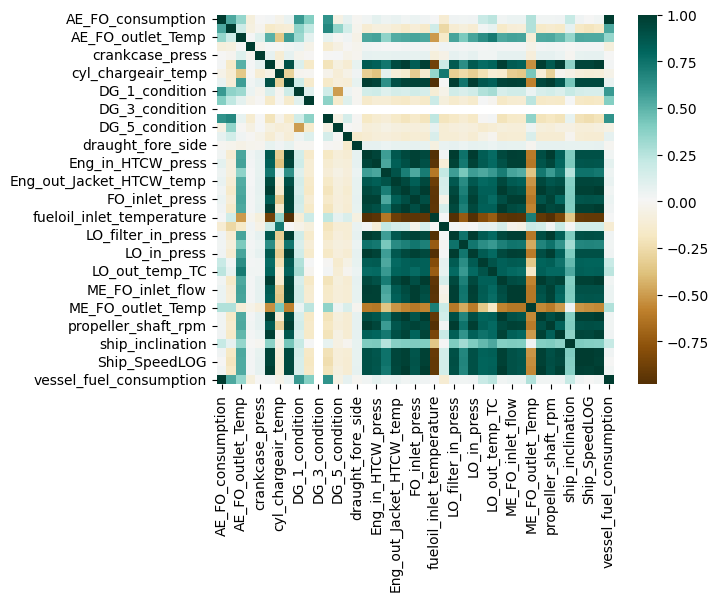

In [19]:
sns.heatmap(data.corr(), cmap='BrBG')

In [ ]:
cols_to_use = [
            'measurement_time','DG_1_condition',
            'DG_2_condition',
            'DG_4_condition','DG_5_condition',
            'ship_inclination'
        ]
fig, ax = plt.subplots(1,4, figsize=(7, 7))
plt.subplots_adjust(right = 3)
sns.countplot(x=normalized_data['DG_1_condition'], ax=ax[0])
sns.countplot(x=normalized_data['DG_2_condition'], ax=ax[1])
sns.countplot(x=normalized_data['DG_4_condition'], ax=ax[2])
sns.countplot(x=normalized_data['DG_5_condition'], ax=ax[3])

In [ ]:
sns.countplot(x=normalized_data['ship_inclination'])